In [1]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from cliffs_delta import cliffs_delta

from ecoselekt.settings import settings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
EXP_ID = "apch"
MODEL_HISTORY = 15

PROJECTS = [
    "activemq",
    "camel",
    "cassandra",
    "flink",
    "groovy",
    "hbase",
    "hive",
    "ignite",
]

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
all_latency_df = pd.DataFrame(columns=["project", "window", "commit_id", "eco_pred_time", "base_pred_time"])
for project in PROJECTS:
    latency_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_inf_perf.csv")
    latency_df["project"] = project
    all_latency_df = pd.concat([all_latency_df, latency_df], ignore_index=True)

all_latency_df["eco_pred_time"] = all_latency_df["eco_pred_time"] * 1000
all_latency_df["base_pred_time"] = all_latency_df["base_pred_time"] * 1000

all_latency_df.head()

,project,window,commit_id,eco_pred_time,base_pred_time
0,activemq,15,014773936022e72b4f8fdff90a0f9fdc33c9b247,178.688049,28.911829
1,activemq,15,02538ed9061b1a57c1a8b0c5accff76465429da0,181.668997,15.243053
2,activemq,15,02ef3dc91846b209dbcf9b65cced501bda2d8280,155.378342,14.645815
3,activemq,15,0484af1c61ca26ce8ea7e2decf953052e0a7ad1e,170.011759,16.166925
4,activemq,15,093b0e2370ebd4c133fa2f110a39ac53dd1bb699,161.844969,14.708996


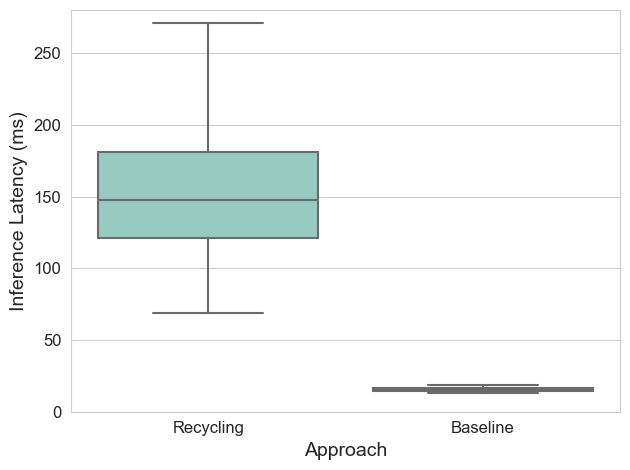

In [4]:
# plot boxplot of inference latency for both eco and base models in one plot
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(all_latency_df[["eco_pred_time", "base_pred_time"]].rename(columns={"eco_pred_time": "Recycling", "base_pred_time": "Baseline"})),
    palette="Set3",
    showfliers=False,
)
# start from 0 y-axis
p.set_ylim(0, 280)
# increase font size
p.tick_params(labelsize=12)
p.set_xlabel("Approach", fontsize=14)
p.set_ylabel("Inference Latency (ms)", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
ALPHA = 0.05

stat_df = pd.DataFrame(columns=["project", "significant", "effect_size"])

for project in PROJECTS:
    temp_df = all_latency_df[all_latency_df["project"] == project]
    _, p = wilcoxon(temp_df["eco_pred_time"], temp_df["base_pred_time"])
    print(f"Significant? -> {p < ALPHA}")
    res = None
    if p < ALPHA:
        d, res = cliffs_delta(temp_df["eco_pred_time"], temp_df["base_pred_time"])
        print(f"Cliff's Delta -> {d}, {res}")
    eco_med = temp_df["eco_pred_time"].median()
    base_med = temp_df["base_pred_time"].median()
    factor = eco_med / base_med
    print(f"Median factor -> {factor}")
    stat_df = stat_df.append({"project": project, "significant": p, "effect_size": res, "eco_med": eco_med, "base_med": base_med, "factor": factor}, ignore_index=True)

stat_df

Significant? -> True
Cliff's Delta -> 0.9962975, large
Median factor -> 7.597903134917132
Significant? -> True
Cliff's Delta -> 0.9998722742513585, large
Median factor -> 10.356288733823563
Significant? -> True
Cliff's Delta -> 0.9999539375, large
Median factor -> 8.888836382456876
Significant? -> True
Cliff's Delta -> 0.9989490650969529, large
Median factor -> 10.676043322367251
Significant? -> True
Cliff's Delta -> 0.999957, large
Median factor -> 9.286589014483969
Significant? -> True
Cliff's Delta -> 0.9987870510396976, large
Median factor -> 9.001017795518546
Significant? -> True
Cliff's Delta -> 0.9992857142857143, large
Median factor -> 8.5978620732736
Significant? -> True
Cliff's Delta -> 0.9996980625, large
Median factor -> 9.324850038776265


,project,significant,effect_size,eco_med,base_med,factor
0,activemq,0.0,large,122.155428,16.077518,7.597903
1,camel,0.0,large,158.170104,15.272856,10.356289
2,cassandra,0.0,large,141.266942,15.892625,8.888836
3,flink,0.0,large,172.149539,16.124845,10.676043
4,groovy,0.0,large,135.056496,14.543176,9.286589
5,hbase,0.0,large,134.943247,14.991999,9.001018
6,hive,0.0,large,131.262660,15.266895,8.597862
7,ignite,0.0,large,140.469551,15.064001,9.324850


In [6]:
print(stat_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrr}
\toprule
  project &  significant & effect\_size &  eco\_med &  base\_med &  factor \\
\midrule
 activemq &        0.000 &       large &  122.155 &    16.078 &   7.598 \\
    camel &        0.000 &       large &  158.170 &    15.273 &  10.356 \\
cassandra &        0.000 &       large &  141.267 &    15.893 &   8.889 \\
    flink &        0.000 &       large &  172.150 &    16.125 &  10.676 \\
   groovy &        0.000 &       large &  135.056 &    14.543 &   9.287 \\
    hbase &        0.000 &       large &  134.943 &    14.992 &   9.001 \\
     hive &        0.000 &       large &  131.263 &    15.267 &   8.598 \\
   ignite &        0.000 &       large &  140.470 &    15.064 &   9.325 \\
\bottomrule
\end{tabular}

